<a href="https://colab.research.google.com/github/HayBeeCoder/visio-computativa/blob/main/image_classification_using_cifar_10_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **SETUP & DATA PREPARATION**

In [42]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
from collections import Counter
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from torch.utils.data import DataLoader, random_split
# from torchinfo import summary
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image


In [2]:
if torch.cuda.is_available():
   device = "cuda"
elif torch.backends.mps.is_available():
   device = "mps"
else:
   device = "cpu"

print(f"Using {device} device.")


Using cuda device.


In [3]:
class ConvertToRGB:
  def __call__(self, image):
    if image.mode != "RGB":
      image = image.convert("RGB")
    return image

In [6]:
transform = transforms.Compose([
    ConvertToRGB(),
    transforms.ToTensor()
])

In [8]:
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

100%|██████████| 170M/170M [00:03<00:00, 43.1MB/s]


In [9]:
trainset[0][0].size

counter = 0
for item in trainset:
  if item[0].size == (32,32):
    counter += 1
print(counter)


0


In [11]:
batch_size=32
train_data_loader = DataLoader(trainset, batch_size=batch_size)

In [12]:
first_batch = next(iter(train_data_loader))

print(f"Shape of one batch: {first_batch[0].shape}")
print(f"Shape of labels: {first_batch[1].shape}")


Shape of one batch: torch.Size([32, 3, 32, 32])
Shape of labels: torch.Size([32])


In [26]:

counts = Counter(x[1] for x in tqdm(trainset))
# print("The counts dictionary:", counts)

# print("The class_to_idx dictionary:", trainset.class_to_idx)

class_distribution = {x: counts[trainset.class_to_idx[x]] for x in trainset.class_to_idx }
print(class_distribution)

  0%|          | 0/50000 [00:00<?, ?it/s]

The counts dictionary: Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})
The class_to_idx dictionary: {'airplane': 0, 'automobile': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}
{'airplane': 5000, 'automobile': 5000, 'bird': 5000, 'cat': 5000, 'deer': 5000, 'dog': 5000, 'frog': 5000, 'horse': 5000, 'ship': 5000, 'truck': 5000}


# **DATA ANALYSIS & NORMALIZATION**

In [18]:
def get_mean_std(loader):

  channels_sum, channels_squared_sum, num_batches = 0, 0, 0
  for data, _ in tqdm(loader, desc="Computing mean and std", leave=False):
    channels_sum += torch.mean(data, dim=[0, 2, 3])
    channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
    num_batches += 1
  mean = channels_sum / num_batches
  std = (channels_squared_sum / num_batches - mean**2) ** 0.5

  return mean, std

In [20]:
mean, std = get_mean_std(train_data_loader)

Computing mean and std:   0%|          | 0/1563 [00:00<?, ?it/s]

In [21]:
transform_norm = transforms.Compose([
    ConvertToRGB(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [27]:
normalized_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_norm)

# **DATA SPLITTING AND VALIDATION**

In [29]:

g = torch.Generator()
g.manual_seed(42)
train_set, val_set = random_split(normalized_trainset, [0.8, 0.2], generator=g)

In [30]:
len(train_set)

40000

In [38]:


def count(dataset):
  counts = Counter(x[1] for x in tqdm(dataset))
  classes = dataset.dataset.class_to_idx
  return pd.Series({cat: counts[index] for cat, index in classes.items() })

count(train_set)

  0%|          | 0/40000 [00:00<?, ?it/s]

,0
airplane,4027
automobile,3990
bird,3994
cat,4033
deer,4037
dog,3976
frog,3975
horse,3965
ship,4002
truck,4001


In [47]:
train_class_distribution = count(train_set)
val_class_distribution = count(val_set)

  0%|          | 0/40000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

(2000.0, 4000.0)

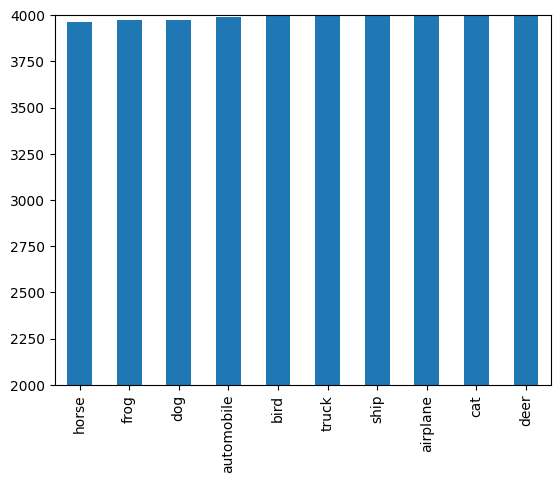

In [45]:
train_class_distribution.sort_values().plot(kind="bar")
plt.ylim(2000,4000)

<Axes: >

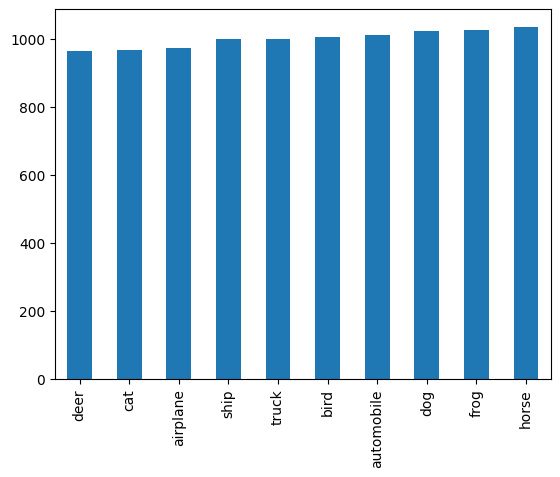

In [48]:
val_class_distribution.sort_values().plot(kind="bar")

# **CNN MODEL ARCHITECTURE**